In [22]:
# code for run on google colab
"""
!pip install git+https://github.com/Kaggle/kaggle-api.git --upgrade
import os
credentials = {"username":"kaggle_username","key":"Kaggle_API_keys"}
os.environ['KAGGLE_USERNAME']=credentials["username"]
os.environ['KAGGLE_KEY']=credentials["key"]
!kaggle datasets download -d moltean/fruits
!unzip fruits.zip
"""

'\n!pip install git+https://github.com/Kaggle/kaggle-api.git --upgrade\nimport os\ncredentials = {"username":"kaggle_username","key":"Kaggle_API_keys"}\nos.environ[\'KAGGLE_USERNAME\']=credentials["username"]\nos.environ[\'KAGGLE_KEY\']=credentials["key"]\n!kaggle datasets download -d moltean/fruits\n!unzip fruits.zip\n'

In [23]:
# Librairies

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
# Import dataset for Google Colab
"""
data_dir = '/content/fruits-360'
print('Folders :', os.listdir(data_dir))
classes = os.listdir(data_dir + "/Training")
print('131 classes :', classes)
"""

'\ndata_dir = \'/content/fruits-360\'\nprint(\'Folders :\', os.listdir(data_dir))\nclasses = os.listdir(data_dir + "/Training")\nprint(\'131 classes :\', classes)\n'

In [25]:
# Import dataset for Kaggle. 

data_dir = '../input/fruits/fruits-360'
print('Folders :', os.listdir(data_dir))
classes = os.listdir(data_dir + "/Training")
print('131 classes :', classes)

Folders : ['Training', 'LICENSE', 'test-multiple_fruits', 'papers', 'readme.md', 'Test']
131 classes : ['Nectarine Flat', 'Peach 2', 'Nut Pecan', 'Pear Williams', 'Pomegranate', 'Granadilla', 'Tangelo', 'Pear Red', 'Apple Golden 3', 'Cherry Wax Black', 'Papaya', 'Apple Red 3', 'Apple Pink Lady', 'Pepper Yellow', 'Cactus fruit', 'Corn Husk', 'Grapefruit White', 'Beetroot', 'Pear Abate', 'Raspberry', 'Dates', 'Avocado', 'Strawberry', 'Cherry 1', 'Pear', 'Rambutan', 'Pear Forelle', 'Avocado ripe', 'Plum 3', 'Tomato not Ripened', 'Tomato 3', 'Cherry 2', 'Peach', 'Tamarillo', 'Huckleberry', 'Pepino', 'Pitahaya Red', 'Carambula', 'Apple Red Delicious', 'Apple Braeburn', 'Onion Red', 'Mangostan', 'Grapefruit Pink', 'Cherry Wax Red', 'Blueberry', 'Passion Fruit', 'Corn', 'Redcurrant', 'Cantaloupe 1', 'Peach Flat', 'Pepper Orange', 'Grape White', 'Quince', 'Pineapple Mini', 'Kumquats', 'Pear Kaiser', 'Apple Golden 1', 'Apricot', 'Pepper Red', 'Walnut', 'Maracuja', 'Salak', 'Kiwi', 'Cucumber Rip

In [26]:
dataset = ImageFolder(data_dir + '/Training', transform=ToTensor())
print('Size of training dataset :', len(dataset))
test = ImageFolder(data_dir + '/Test', transform=ToTensor())
print('Size of test dataset :', len(test))

Size of training dataset : 67692
Size of test dataset : 22688


In [27]:
# view one image shape of the dataset.
img, label = dataset[599]
print(img.shape)

torch.Size([3, 100, 100])


Label:  Apple Crimson Snow (1)


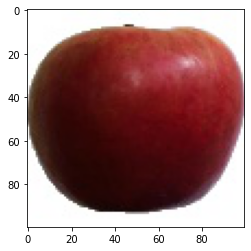

In [28]:
# function for the showing the image.
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    
show_image(*dataset[599])

Label:  Grape White (46)


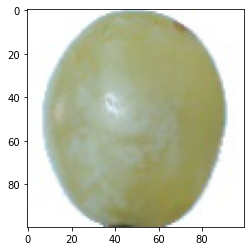

In [29]:
show_image(*dataset[23480])

In [30]:
torch.manual_seed(20)
val_size = len(dataset)//10
train_size = len(dataset) - val_size

In [31]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds) # train_ds length = dataset length - val_ds length

(60923, 6769)

In [32]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test, batch_size*2, num_workers=4, pin_memory=True)

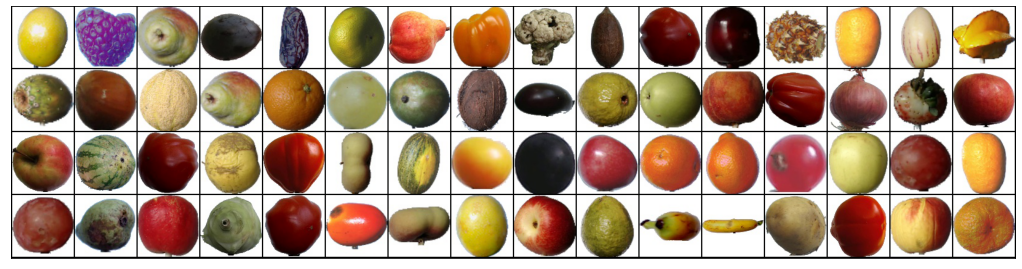

In [33]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [34]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [35]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [36]:
torch.cuda.is_available()

True

In [37]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = get_default_device()
device

device(type='cuda')

In [38]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [39]:
input_size = 3*100*100
output_size = 131 # Number of classe
class Model(ImageClassificationBase):
    def __init__(self, input_size, output_size):
        super().__init__()
        # hidden layer
        self.in_layer = nn.Linear(input_size, 8384)
        self.hidden1 = nn.Linear(8384, 4192)
        self.hidden2 = nn.Linear(4192, 2096)
        self.hidden3 = nn.Linear(2096, 1048)
        self.out_layer = nn.Linear(1048, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        # Input layer
        out = self.in_layer(out)
        # Hidden layers w/ ReLU
        out = self.hidden1(F.relu(out))
        out = self.hidden2(F.relu(out))
        out = self.hidden3(F.relu(out))
        # Class output layer
        out = self.out_layer(F.relu(out))
        return out
model = to_device(Model(input_size, output_size), device)
history = [evaluate(model, val_loader)]
history

[{'val_loss': 4.875558376312256, 'val_acc': 0.006210605148226023}]

In [40]:
history += fit(7, 0.01, model, train_loader, val_loader)


Epoch [0], train_loss: 4.2462, val_loss: 2.9851, val_acc: 0.2024



Epoch [1], train_loss: 2.1398, val_loss: 1.3889, val_acc: 0.5791



Epoch [2], train_loss: 1.1122, val_loss: 0.5844, val_acc: 0.8318



Epoch [3], train_loss: 0.7072, val_loss: 0.4097, val_acc: 0.8605



Epoch [4], train_loss: 0.4700, val_loss: 0.2359, val_acc: 0.9333



Epoch [5], train_loss: 0.3499, val_loss: 5.4661, val_acc: 0.2210



Epoch [6], train_loss: 0.2710, val_loss: 0.1333, val_acc: 0.9570


In [41]:
history += fit(8, 0.001, model, train_loader, val_loader)


Epoch [0], train_loss: 0.0731, val_loss: 0.0729, val_acc: 0.9852



Epoch [1], train_loss: 0.0639, val_loss: 0.0666, val_acc: 0.9870



Epoch [2], train_loss: 0.0586, val_loss: 0.0625, val_acc: 0.9886



Epoch [3], train_loss: 0.0546, val_loss: 0.0597, val_acc: 0.9875



Epoch [4], train_loss: 0.0513, val_loss: 0.0559, val_acc: 0.9904



Epoch [5], train_loss: 0.0485, val_loss: 0.0530, val_acc: 0.9906



Epoch [6], train_loss: 0.0460, val_loss: 0.0509, val_acc: 0.9908



Epoch [7], train_loss: 0.0436, val_loss: 0.0489, val_acc: 0.9923


In [42]:
history += fit(3, 0.0001, model, train_loader, val_loader)


Epoch [0], train_loss: 0.0410, val_loss: 0.0471, val_acc: 0.9920



Epoch [1], train_loss: 0.0405, val_loss: 0.0468, val_acc: 0.9923



Epoch [2], train_loss: 0.0403, val_loss: 0.0466, val_acc: 0.9920


In [43]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

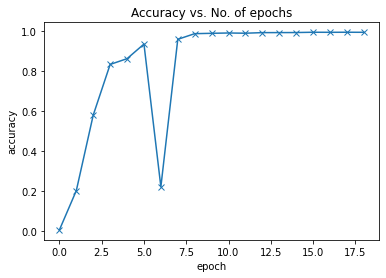

In [44]:
plot_accuracies(history)

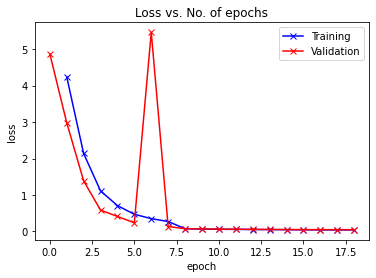

In [45]:
plot_losses(history)

In [46]:
evaluate(model, test_loader)

{'val_loss': 0.4173668324947357, 'val_acc': 0.9018170833587646}

In [47]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [48]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(100, 150, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 150 x 16 x 16

            nn.Conv2d(150, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(200, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 200 x 8 x 8

            nn.Conv2d(200, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(250, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 250 x 4 x 4

            nn.Flatten(), 
            nn.Linear(36000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(500, 131))
        
    def forward(self, xb):
        return self.network(xb)
model = CnnModel()
model.cuda()

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten()
    (16): Linear(in_features=36000, out_features=1000, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1000, out_features=5

In [49]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    #print('out[0]:', out[0])
    break

images.shape: torch.Size([64, 3, 100, 100])
out.shape: torch.Size([64, 131])


In [50]:
 device = get_default_device()
device

device(type='cuda')

In [51]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten()
    (16): Linear(in_features=36000, out_features=1000, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1000, out_features=5

In [52]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [53]:
model = to_device(CnnModel(), device)
history=[evaluate(model, val_loader)]
history

[{'val_loss': 4.875207424163818, 'val_acc': 0.005807522218674421}]

In [54]:
num_epochs = 3
opt_func = torch.optim.Adam
lr = 0.001
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 1.1928, val_loss: 0.1122, val_acc: 0.9645



Epoch [1], train_loss: 0.1042, val_loss: 0.0158, val_acc: 0.9951



Epoch [2], train_loss: 0.0625, val_loss: 0.0199, val_acc: 0.9944


In [55]:
history+= fit(num_epochs, lr/10, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 0.0041, val_loss: 0.0009, val_acc: 0.9997



Epoch [1], train_loss: 0.0024, val_loss: 0.0011, val_acc: 0.9996



Epoch [2], train_loss: 0.0019, val_loss: 0.0011, val_acc: 0.9997


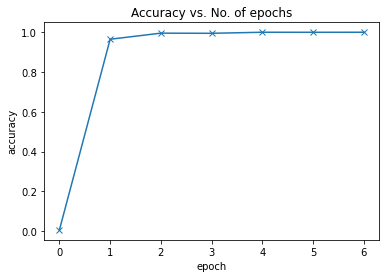

In [56]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()
plot_accuracies(history)

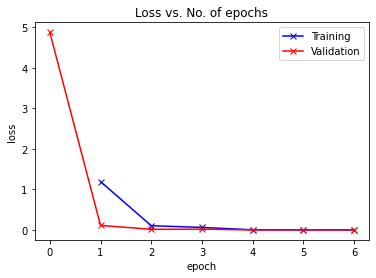

In [57]:
plot_losses(history)

In [58]:
evaluate(model, test_loader)

{'val_loss': 0.47265270352363586, 'val_acc': 0.9389922618865967}

In [60]:
!pip install --upgrade pip

     |████████████████████████████████| 1.5 MB 1.4 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.2.3
    Uninstalling pip-20.2.3:
      Successfully uninstalled pip-20.2.3


In [59]:
!pip install jovian --upgrade --quiet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [61]:
import jovian
jovian.reset()

<IPython.core.display.Javascript object>

In [62]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_accuracy=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'])

[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Metrics logged.


In [63]:
project_name='fruits-360'
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/benvictoria21/fruits-360


<IPython.core.display.Javascript object>